# Along-isobath average

This code shows how to do an along-isobath averaging for scalar properties (and vector properties not rotated to along- and across-contour) in ACCESS-OM2-01.

This code is relevant for Antarctic shelf analyses where a zonal average over a section of cross-shelf regions is needed.

### Some caveats: 

1) If there are deep valleys or troughs around the coastline, those will be averaged with deeper isobaths further offshore. Similarly, if there are seamounts off-shore, these will be averaged with shallower regions on the continental slope. Careful adjustment of the mask is necessary to ensure your results are interpretable. 

2) The bottom depths in ht and hu reflect the adaptive vertical grid in ACCESS, but the variables have NaNs at some of these depths. So, we end up with uneven binning if we bin along isobaths which do not exist in the variable field. As a simple fix, we mask our region of interest by ht and hu, but we bin by the bottom depth derived from the 3D variables (e.g., temperature) -- these are the hu_coarse and ht_coarse variables. This workaround can be further inspected in the future. 


In [1]:
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40729/status,
Dashboard: /proxy/40729/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36787,Workers: 7
Dashboard: /proxy/40729/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:41583,Total threads: 4
Dashboard: /proxy/43505/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:45717,


In [3]:
session = cc.database.create_session()
# Define experiment in database - here we choose the RYF90-91 experiment #
expt = '01deg_jra55v13_ryf9091'

Note that the bathymetry provided by ht and hu is not discretised into the same bins as st_ocean(_edges). The histogram function in this code thus yields uneven bins if we bin ht by st_ocean_edges bins. As a result, we use ht and hu for our masking, but we obtain bottom bathymetry from the variable itself, which IS discretised into st_ocean bins. 

### 1. Define your region of interest. 
Bathymetry variables, ht and hu, are used for masking unwanted deep regions on the continental shelf and shallow regions offshore.

In [4]:
# Import bathymetry - t-grid #
ht = cc.querying.getvar(expt, 'ht', session, n=1)

# Import bathymetry - u-grid #
hu = cc.querying.getvar(expt, 'hu', session, n=1)

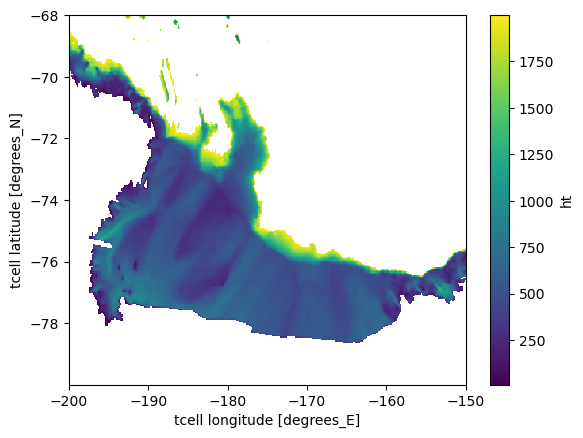

In [5]:
### DEFINE YOUR REGION OF INTEREST ###
# As a simple example, we mask out everything but the Ross Sea shallower than 2000m.
# As an alternative, you can define any polygon as your mask.

lon_slice = slice(-200,-150)
lat_slice = slice(-80,-68)
mask_depth = 2000

# select correct extent of ht, hu for use later:
ht = ht.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
hu = hu.sel(xu_ocean=lon_slice).sel(yu_ocean=lat_slice)

# create masks:
mask_t = ht.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice) < mask_depth
mask_u = hu.sel(xu_ocean=lon_slice).sel(yu_ocean=lat_slice) < mask_depth
mask_t = mask_t.where(mask_t!=0)
mask_u = mask_u.where(mask_u!=0)

# mask bathymetry:
hu_masked = hu*mask_u
ht_masked = ht*mask_t

# Plot the bathymetry in the mask region:
ht_masked.plot()
plt.title('Bathymetry in region of interest')
plt.show()

### 2. Import variables for averaging, set up thickness and area for weighting, and isobath bins.

In [6]:
# Import properties to average along isobaths.

# Define the start and end times #
start_time, end_time = '2170-01-01', '2180-12-31'

temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency='1 monthly', chunks={})
temp = temp.sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)

salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency='1 monthly', chunks={})
salt = salt.sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)

density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency='1 monthly', chunks={})
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)

u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly', chunks={})
u = u.sel(time=slice(start_time, end_time)).sel(yu_ocean=lat_slice)
                                               
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency='1 monthly', chunks={})
v = v.sel(time=slice(start_time, end_time)).sel(yu_ocean=lat_slice)

In [7]:
%%time
## Calculating Volume and area for weighted averaging using xhistogram:
## Note that the thickness here is NOT time-varying. Use dzt for time-varying thickness if necessary.

xt_ocean = cc.querying.getvar(expt,'xt_ocean' , session,n=1)
xt_ocean = xt_ocean.sel(xt_ocean=lon_slice)
yt_ocean = cc.querying.getvar(expt,'yt_ocean' , session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

# adjust for partial bottom cells:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:
area_t = cc.querying.getvar(expt,'area_t',session,n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t*thickness
volume = volume.load()

CPU times: user 4.23 s, sys: 1.07 s, total: 5.3 s
Wall time: 6 s


In [8]:
%%time
# As above, for the u-grid #

xu_ocean = cc.querying.getvar(expt,'xu_ocean' , session,n=1)
xu_ocean = xu_ocean.sel(xu_ocean=lon_slice)
yu_ocean = cc.querying.getvar(expt,'yu_ocean' , session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':yu_ocean,'xu_ocean':xu_ocean}, axis=[1,2])

# adjust for partial bottom cells:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:
area_u = cc.querying.getvar(expt,'area_u',session,n=1)
area_u = area_u.sel(yu_ocean=lat_slice)

volume_u = area_u*thickness_u
volume_u = volume_u.load()

CPU times: user 4.36 s, sys: 1.05 s, total: 5.41 s
Wall time: 6.11 s


In [9]:
### MASK YOUR REGION OF INTEREST ###

volume_masked = volume*mask_t
volume_u_masked = volume_u*mask_u
area_t_masked = area_t*mask_t
area_u_masked = area_u*mask_u
temp_masked = temp*mask_t
salt_masked = salt*mask_t
density_masked = density*mask_t
u_masked = u*mask_u

In [10]:
%%time
## As mentioned above, we don't use ht and hu for the histogram binning below, as our variable depth bins are st_edges_ocean, 
## while ht and hu have much finer resolution, leading to uneven bins. 

## Below, we isolate the bottom st_ocean of temp (as ht_coarse) and u (as hu_coarse) that isn't NaN. This is the variable over
## which we perform the binning. Note that we assume that NaN grid cells are NaN at all times (i.e., ht_coarse and hu_coarse don't change over time)

###### T-GRID ######

# Create an empty DataArray with the same shape as 'temp_avg'
temp_avg = temp_masked.mean('time')
full_st_ocean_t = xr.full_like(temp_avg, np.nan)

# Assign the 1D st_ocean coordinate to the new DataArray, broadcasting along the other dimensions
full_st_ocean_t.data = np.broadcast_to(temp_avg.st_ocean.values[:, np.newaxis, np.newaxis], temp_avg.shape)
full_st_ocean_t_masked = full_st_ocean_t*temp_avg/temp_avg # Here, we mask by temp_avg to ensure the Nans are preserved 

# Now 'full_st_ocean_t_masked' is a 3D DataArray with 'st_ocean' values broadcasted along yt_ocean and xt_ocean
# and masked by temp_avg

# Find the bottom depth for each (yt_ocean, xt_ocean) coordinate
ht_coarse = full_st_ocean_t_masked.max(dim='st_ocean').compute().rename('ht_coarse')

###### U-GRID ######

# Create an empty DataArray with the same shape as 'u_avg'
u_avg = u_masked.mean('time')
full_st_ocean_u = xr.full_like(u_avg, np.nan)

# Assign the 1D st_ocean coordinate to the new DataArray, broadcasting along the other dimensions
full_st_ocean_u.data = np.broadcast_to(u_avg.st_ocean.values[:, np.newaxis, np.newaxis], u_avg.shape)
full_st_ocean_u_masked = full_st_ocean_u*u_avg/u_avg # Here, we mask by u_avg to ensure the Nans are preserved 

# Now 'full_st_ocean_u_masked' is a 3D DataArray with 'st_ocean' values broadcasted along yu_ocean and xu_ocean
# and masked by u_avg

# Find the bottom depth for each (yu_ocean, xu_ocean) coordinate
hu_coarse = full_st_ocean_u_masked.max(dim='st_ocean').compute().rename('hu_coarse')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 4min 27s, sys: 6.97 s, total: 4min 34s
Wall time: 4min 52s


### 3. Bin variables into isobath depth!

In [11]:
%%time
### This section bins variables of interest by isobath using xhistogram #

# First, we define the edges of the isobath bins - it makes sense for these to be the same as st_edges_ocean #
# because that is the vertical resolution of the ACCESS-OM2-01 model #
bins_isobath = st_edges_ocean.where(st_edges_ocean<=mask_depth).dropna(dim='st_edges_ocean').values

# Next, we sum the volume-weighted variable of interest along that isobath using xhistogram
V_sum = histogram(ht_coarse, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume_masked)
Vu_sum = histogram(hu_coarse, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u_masked)

A_sum = histogram(ht_coarse, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t_masked)
Au_sum = histogram(hu_coarse, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u_masked)

TV_sum = histogram(ht_coarse, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume_masked*temp_masked)
SV_sum = histogram(ht_coarse, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume_masked*salt_masked)
rhoV_sum = histogram(ht_coarse, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume_masked*density_masked)
uV_sum = histogram(hu_coarse, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u_masked*u_masked)

# Finally, we divide the summed, volume-weighted variable of interest by volume, to get a mean along an isobath

T_mean = TV_sum/V_sum
S_mean = SV_sum/V_sum
rho_mean = rhoV_sum/V_sum
u_mean = uV_sum/Vu_sum

T_mean.load()
rho_mean.load()
S_mean.load()
u_mean.load();

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

CPU times: user 2min 17s, sys: 7.46 s, total: 2min 25s
Wall time: 2min 54s


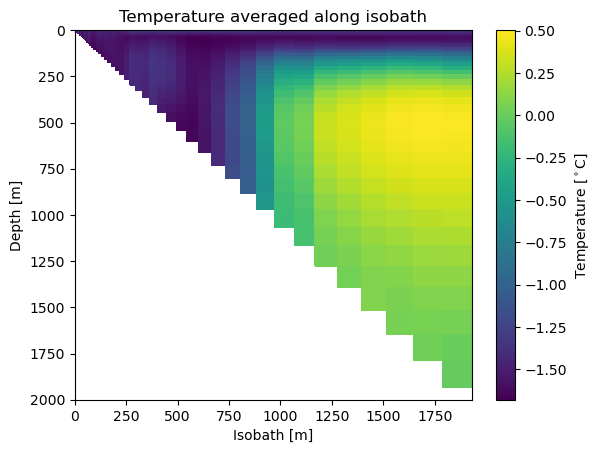

In [16]:
## The binning above creates an averaged field as a function of isobath ##
# Let's plot this to see what it looks like 

plt.pcolor(T_mean.ht_coarse_bin, st_ocean, T_mean.mean('time')-273.15)
plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.xlabel('Isobath [m]')
plt.ylabel('Depth [m]')
plt.colorbar(label = 'Temperature [$^\circ$C]')
plt.title('Temperature averaged along isobath')
plt.show()

## Each variable is averaged along isobaths, so the bathymetry looks diagonal in the plot #


In [57]:
## We can rescale the isobath (x-axis) to be scaled by the cumulative 
## surface area covered by each isobath, from shallowest to deepest.

## This produces a 'normalised area' or pseduo-latitude x-axis ##

normalised_area_cumsum = (A_sum.cumsum('ht_coarse_bin')/np.nansum(A_sum)).values
normalised_area_cumsum_u = (Au_sum.cumsum('hu_coarse_bin')/np.nansum(Au_sum)).values

lat_max, lat_min = abs(mask_t.yt_ocean.max().values), abs(mask_t.yt_ocean.min().values)

## Here, we plot the averaged quantities as a function of normalised area (between 0 and 1)
## and pseudo-latitude
def normalised_to_pseudo_lat(normalised_area):
    return -1 * (lat_min - (lat_min - lat_max) * normalised_area)

def pseudo_lat_to_normalised(pseudo_lat):
    return (lat_min + pseudo_lat) / (lat_min - lat_max)

pseudo_lat = normalised_to_pseudo_lat(normalised_area_cumsum)
pseudo_lat_u = normalised_to_pseudo_lat(normalised_area_cumsum_u)

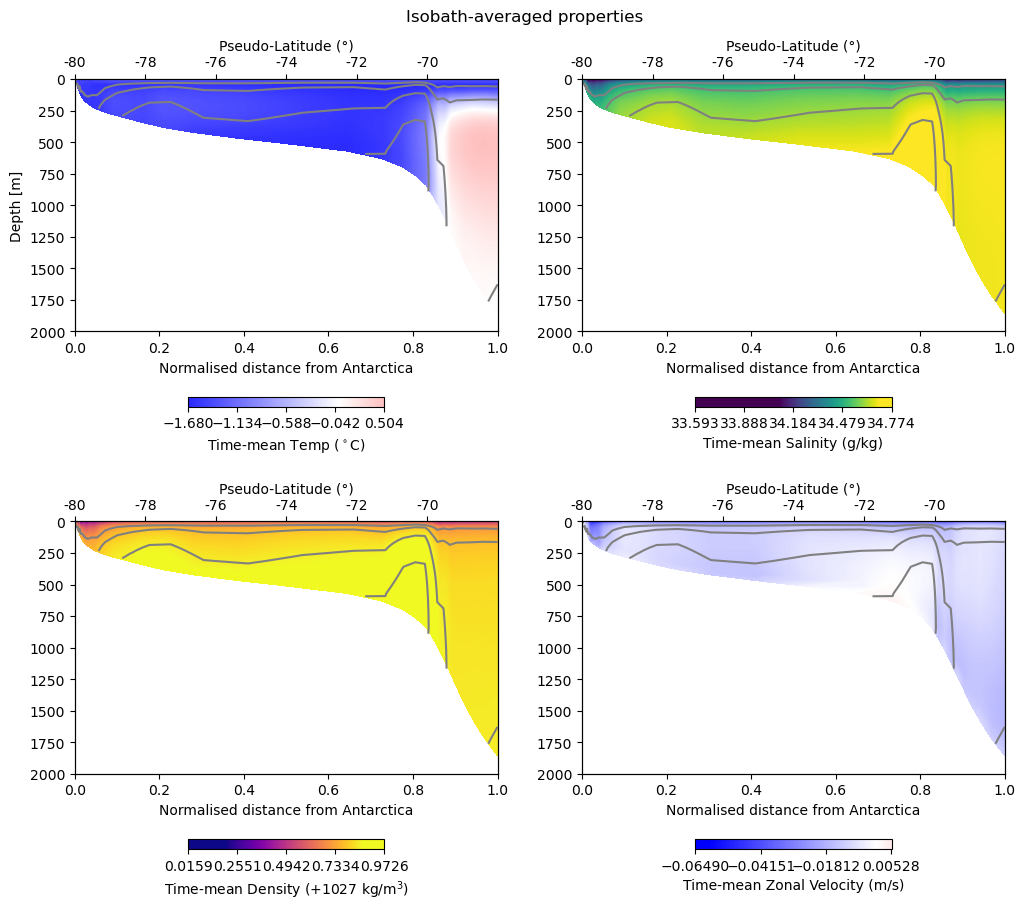

In [56]:
## Finally, plot the isobath-averaged properties. 

fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.2)
axs = axs.ravel()

fontsize = 13


im1 = axs[0].contourf(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, levels=500, \
                      vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].contourf(normalised_area_cumsum, st_ocean, S_mean.mean('time'), levels=500, vmin=34.1,  \
                      vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].contourf(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, levels=500, \
                      vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].contourf(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), levels=500, \
                      vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

density_contours = np.linspace(1027.7, 1028, 5)


for i, ax in enumerate(axs):
    cont = ax.contour(normalised_area_cumsum_u, st_ocean, rho_mean.mean('time'), density_contours,
                      colors='gray', zorder=2, fontsize=fontsize)
    ax.invert_yaxis()
    ax.set_xlabel('Normalised distance from Antarctica')
    ax.set_ylim(mask_depth, 0)

    # Secondary x-axis: pseudo_lat
    twin_ax = ax.twiny()
    twin_ax.set_xlim(ax.get_xlim())  # Align the limits to match the shared x-axis
    twin_ax.set_xticks(pseudo_lat_to_normalised(np.arange(-80,-68,2)))  # Match tick positions
    twin_ax.set_xticklabels(np.arange(-80,-68,2))  # Replace tick labels with pseudo_lat values
    twin_ax.set_xlabel('Pseudo-Latitude (°)')

# for i in range(4):
#     axs[i].invert_yaxis()
#     axs[i].set_xlabel('Normalised distance from Antarctica')
#     axs[i].set_ylim(mask_depth, 0)

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.2, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.2, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.2, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.2, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

cb1.set_ticks(np.linspace(np.min(T_mean.mean('time')-273.15), np.max(T_mean.mean('time')-273.15),5))
cb2.set_ticks(np.linspace(np.min(S_mean.mean('time')), np.max(S_mean.mean('time')),5))
cb3.set_ticks(np.linspace(np.min(rho_mean.mean('time')-1027), np.max(rho_mean.mean('time')-1027),5))
cb4.set_ticks(np.linspace(np.min(u_mean.mean('time')), np.max(u_mean.mean('time')),4))

plt.suptitle('Isobath-averaged properties', y=0.95)
plt.show()